In [2]:
import cv2 as cv
import numpy as np
from scipy import linalg
from matplotlib import pyplot as plt

In [25]:
video = cv.VideoCapture("/Users/nadaelarabi/Data-driven-dynamical-systems/SlidingWindowDMD/V2R2.mp4")
frames = []
ret = True
while ret:
    ret,img = video.read()
    if ret:
        greyscale = np.mean(img,-1)
        frames.append(greyscale)
video2=np.stack(frames,axis=0)
video2.shape
videoDataTranspose = video2.T
widthVideo = videoDataTranspose.shape[0]
heightVideo = videoDataTranspose.shape[1]
numberPixelsPerFrame = widthVideo * heightVideo
numberOfFrames = videoDataTranspose.shape[2]

#Here we can reshape the data to have each frame represented as columns stacked
dataMat = (np.reshape(video2,(numberOfFrames,numberPixelsPerFrame))).transpose()

In [26]:
u,s,vt = np.linalg.svd(dataMat,full_matrices=False)
#Now we find the median value of the singular values
s
median = np.median(s)
print(median)
#Now we can compute tau, as per Gavish and Donoho, 2014
m = dataMat.shape[0] #Here we are simply storing dimensions of rows, clomuns of X
n = dataMat.shape[1]

beta = 1-(n/m)
omega = 0.56*(beta*beta*beta) - 0.95*(beta*beta) + 1.82*beta + 1.43
tau = omega*median
print(beta)
print(omega)
print(tau)

1544.0581174553683
0.9992784626540971
2.8588459200859786
4414.224249462916


In [27]:
#Here we just determine how many singular values are important
counter = 0
i=0
while tau<s[i]:
    i=i+1
    counter=counter+1
    
print('The number of significant modes is:', counter)
nb_modes = 40

The number of significant modes is: 55


In [52]:
#Since we only have 165 important modes, we should truncate our matrix U
nb_modes = counter
u,s,vt = np.linalg.svd(dataMat,full_matrices=False)
u = u[:,0:nb_modes]
u.shape


(275800, 55)

In [53]:
#Now we multiply U* by our data matrix to obtain our SxN matrix
#data_reduced=np.matmul((u.T),dataMat)
# u,s,vt = np.linalg.svd(dataMat,full_matrices=False)
# data_reduced = u[:,0:165].conj().T @ Transpose_frames #Creates the low rank matrix
#data_reduced = u.T @ dataMat
data_reduced = np.matmul((u.T),dataMat)
data_reduced.shape
n = data_reduced.shape[1]
X = data_reduced[:,0:n-1]
Y = data_reduced[:,1:n]

X.shape
#Now we can create our low rank matrix A
Xt = np.linalg.pinv(X)
#A = np.matmul(Y,Xt)
A  = Y @ Xt
A.shape

(55, 55)

Text(0.5, 1.0, 'Plot of Discrete Time Eigenvalues $\\mu$')

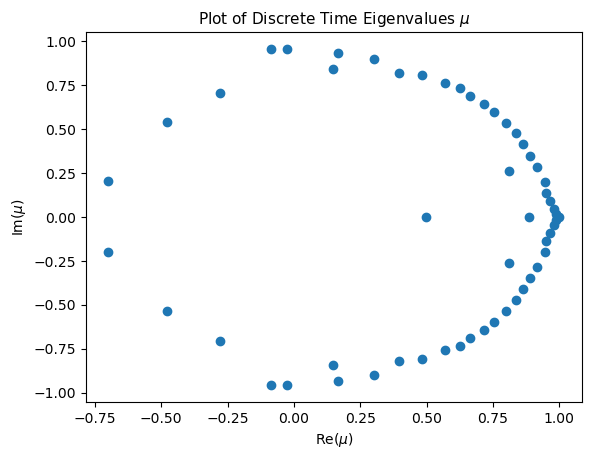

In [54]:
eigenvalues, eigenvectors = np.linalg.eig(A)
plt.scatter(eigenvalues.real,eigenvalues.imag)
plt.xlabel("Re($\mu$)")
plt.ylabel("Im($\mu$)")
plt.title("Plot of Discrete Time Eigenvalues $\mu$",fontsize=11)

# reals = eigenvalues.real
# imagin = eigenvalues.imag
# plt.plot(reals,imagin,'g*') #where I divided by 6/379
# plt.ylabel('Imaginary')
# plt.xlabel('Real')
# plt.title("Plot of Discrete Time step Eigenvalues $\mu$",fontsize=10)
# plt.show()

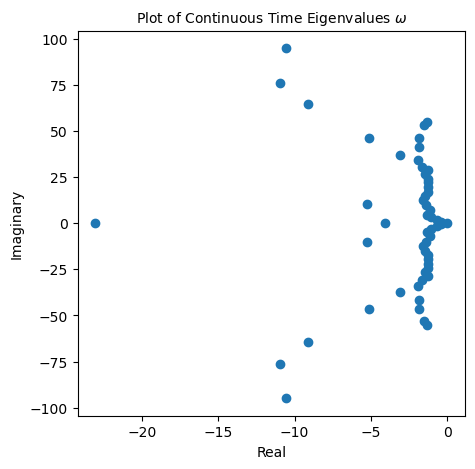

In [55]:
omega = [] # set of transformed eigenvalues 
nb_frames = video2.T.shape[2]
dt =6/nb_frames

for eigenvalue in eigenvalues:
  omegak = np.log(eigenvalue)/dt
  omega.append(omegak)

omega = np.array(omega)


# We can plot the continuous time eigenvalues 
plt.figure(figsize=(5,5))
plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.title("Plot of Continuous Time Eigenvalues $\omega$",fontsize=10)
plt.scatter((omega).real,(omega).imag)

Text(0.5, 1.0, 'Background')

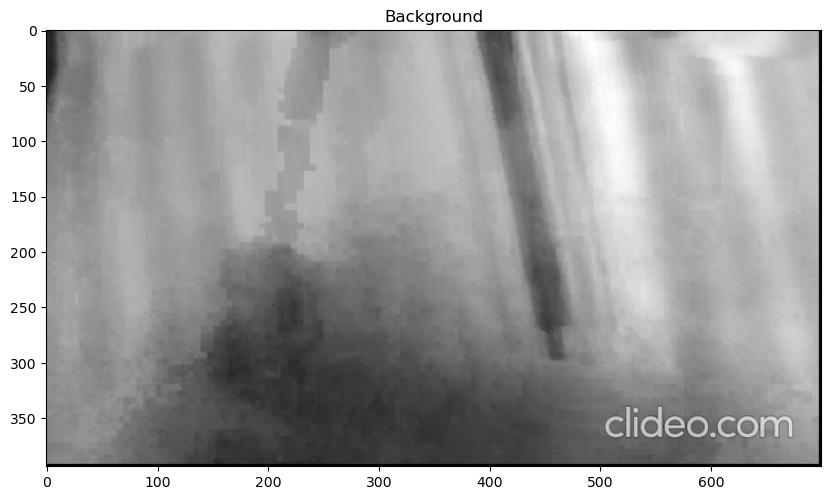

In [56]:
num_of_sings = nb_modes
new_videodata = data_reduced
#Only need this if the using opencv
number_of_frames = numberOfFrames
height = heightVideo
width = widthVideo
########################
A = Y @ np.linalg.pinv(X)


# Find coefficients of the eigendecomposition 

b = np.linalg.pinv(eigenvectors) @ X[:,0]

b.shape

plt.figure(figsize=(10,10))

#plt.imshow(np.reshape(u[:,0:num_of_sings]@new_videodata[:,300].real, (height, width)),cmap='gray') #since values in xdmd are real and imaginary part is really close to 0, I'm taking

slow_index = []
for i in range(len(omega)):
  if abs(omega[i])<0.00000001:
    slow_index.append(i)

b_slow = np.zeros(b.shape).astype(complex)

for i in slow_index:
  b_slow[i] = b[i]

np.array(slow_index).shape


slow_x = np.zeros((num_of_sings,number_of_frames)).astype('complex')

for i in range(number_of_frames):
  for j in range(num_of_sings):
    if b_slow[j]!=0:
      slow_x[:,i] = slow_x[:,i]+(b[j]* np.exp(omega[j]*i))*eigenvectors[:,j]

plt.imshow(np.reshape((u[:,0:num_of_sings]@slow_x[:,100]).real,(height, width)),cmap = 'gray')


# Create x_sparse 
x_sparse = new_videodata - np.abs(slow_x)


# Create the matrix R 
new_r =np.zeros(x_sparse.shape)

for i in range(number_of_frames):
  for j in range(num_of_sings):
    if x_sparse[j,i].real <0:
      new_r[j,i] = x_sparse[j,i]



# Reassign them as mentioned in assignment 1 
new_sparse = x_sparse - new_r

new_slow =np.abs(slow_x) + new_r 


plt.imshow(np.reshape((u[:,0:num_of_sings]@ new_sparse[:,97]),(height, width)),cmap = 'gray')
plt.title("Foreground")

plt.imshow(np.reshape((u[:,0:num_of_sings]@ new_slow[:,97]),(height, width)),cmap = 'gray')
plt.title("Background")

In [57]:
omega = np.absolute(omega)
omega = np.square(omega)

In [58]:
omega = np.array(omega)

In [59]:
concatenated_eigenvalues = np.reshape(omega,(omega.shape[0],1))

In [60]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(concatenated_eigenvalues)
kmeans.cluster_centers_

array([[ 399.20475843],
       [7519.17194076],
       [2691.10775977]])